# Imports and configs

In [1]:
!pip install autogluon.tabular scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.4/382.4 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import pickle
import os

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e7/train.csv"
    test_path = "/kaggle/input/playground-series-s5e7/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e7/sample_submission.csv"

    original_path = "/kaggle/input/extrovert-vs-introvert-behavior-data-backup/personality_dataset.csv"
    
    target = "Personality"
    n_folds = 5
    seed = 42
    
    log_path = "/logs"
    time_limit = 3600 * 11

# Loading data and defining folds

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

# Reference: https://www.kaggle.com/code/paddykb/ps-s5e7-don-t-look-at-me
original = pd.read_csv(CFG.original_path)
original = original.rename(columns={'Personality': 'match_p'})
original = original.drop_duplicates(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance', 'Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency'])
train = train.merge(original, how='left')
test = test.merge(original, how='left')

In [5]:
skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = skf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, "fold"] = i

# Fitting the predictor

In [6]:
predictor = TabularPredictor(
    path=CFG.log_path,
    problem_type="binary",
    eval_metric="accuracy",
    label=CFG.target,
    groups="fold",
    verbosity=2
)

In [7]:
predictor.fit(
    train_data=train,
    time_limit=CFG.time_limit,
    presets="best_quality"
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.26 GB / 31.35 GB (96.5%)
Disk Space Avail:   1654.95 GB / 8062.39 GB (20.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect st

In [8]:
predictor.leaderboard(silent=True).style.background_gradient(subset=["score_val"], cmap="RdYlGn")

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.972036,accuracy,0.826659,246.946931,0.006721,2.264030,2,True,111
1,WeightedEnsemble_L3,0.971982,accuracy,18.527940,3430.051945,0.003549,2.156011,3,True,220
2,NeuralNetFastAI_r172_BAG_L2,0.971874,accuracy,16.982037,2617.879443,0.354911,67.373278,2,True,197
3,NeuralNetFastAI_r37_BAG_L2,0.971874,accuracy,17.066041,2650.311798,0.438915,99.805634,2,True,162
4,NeuralNetFastAI_BAG_L2,0.971874,accuracy,17.178726,2676.885239,0.551600,126.379075,2,True,119
5,NeuralNetFastAI_r191_BAG_L2,0.971874,accuracy,17.369940,2767.973459,0.742814,217.467294,2,True,126
6,RandomForest_r127_BAG_L2,0.971874,accuracy,17.506318,3109.071125,0.879192,558.564961,2,True,167
7,RandomForest_r39_BAG_L2,0.971874,accuracy,17.517964,3002.191108,0.890838,451.684943,2,True,154
8,RandomForestGini_BAG_L2,0.971874,accuracy,17.535808,2626.136783,0.908682,75.630618,2,True,114
9,NeuralNetFastAI_r95_BAG_L2,0.971874,accuracy,17.594467,2837.396246,0.967341,286.890082,2,True,156


In [9]:
def get_ensemble_weights(predictor):
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
    return ensemble_weights

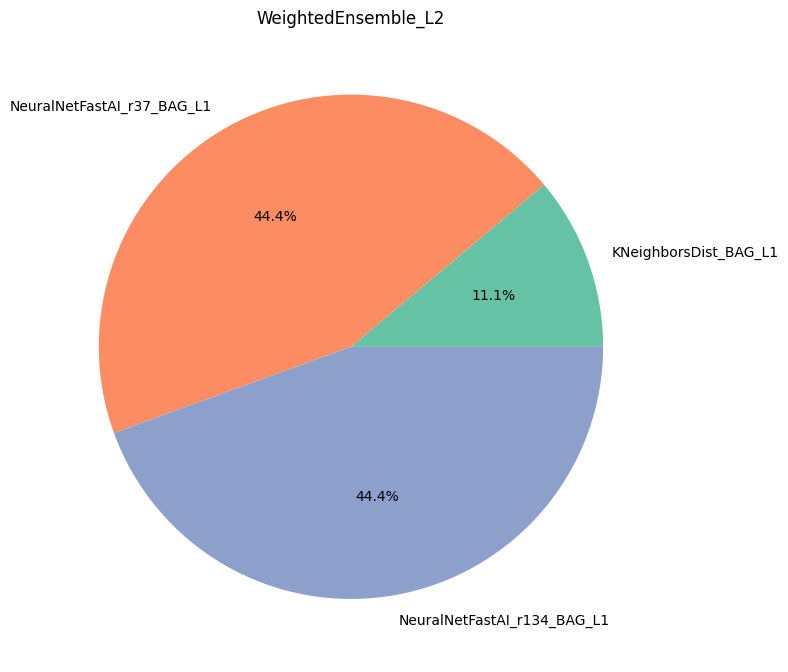

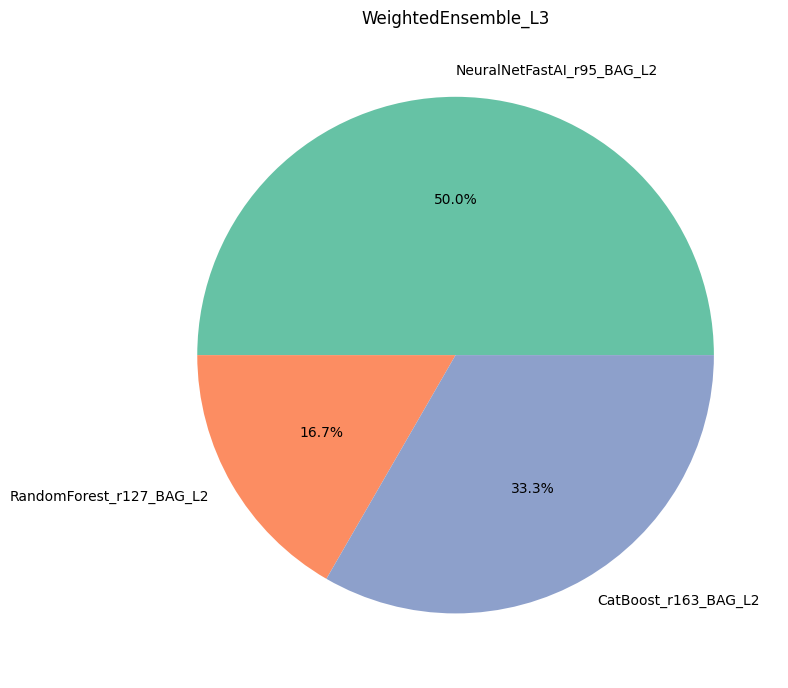

In [10]:
ensemble_weights = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(8, 8))
    plt.pie(value.values(), labels=value.keys(), autopct="%1.1f%%", colors=sns.color_palette("Set2", len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

# Saving OOF files and creating a submission file

In [11]:
def save_pred_probs(pred_probs, cv_score, name, type, is_ensemble):
    base_path = "oof_pred_probs" if type == "oof" else "test_pred_probs"
    base_path = "." if is_ensemble else base_path
    with open(f"{base_path}/{name}_{type}_pred_probs_{cv_score:.6f}.pkl", "wb") as f:
        pickle.dump(pred_probs, f)

def save_submission(test, test_preds, score):        
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_preds
    sub.loc[test.match_p == "Extrovert", CFG.target] = "Introvert"
    sub.loc[test.match_p == "Introvert", CFG.target] = "Extrovert"
    sub.to_csv(f"sub_autogluon_{score:.6f}.csv", index=False)
    
os.makedirs("oof_pred_probs", exist_ok=True)
os.makedirs("test_pred_probs", exist_ok=True)

In [12]:
oof_pred_probs = {}
test_pred_probs = {}
oof_preds = {}

In [13]:
best_model = predictor.model_best
_test_pred_probs = predictor.predict_proba_multi(test)
for model in predictor.model_names():
    model_oof_pred_probs = predictor.predict_proba_oof(model).values[:, 1]
    model_oof_preds = predictor.predict_oof(model).values
    model_test_pred_probs = _test_pred_probs[model].values[:, 1]
    
    cv_score = accuracy_score(train[CFG.target], model_oof_preds)
    if model != best_model:
        save_pred_probs(model_oof_pred_probs, cv_score, model, "oof", False)
        save_pred_probs(model_test_pred_probs, cv_score, model, "test", False)
    else:
        save_pred_probs(model_oof_pred_probs, cv_score, model, "oof", True)
        save_pred_probs(model_test_pred_probs, cv_score, model, "test", True)
        save_submission(test, predictor.predict(test).values, cv_score)
        
    oof_pred_probs[model] = model_oof_pred_probs
    test_pred_probs[model] = model_test_pred_probs
    oof_preds[model] = model_oof_preds

# Visualizing the results

In [14]:
scores = {}
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = accuracy_score(train.loc[val_index, CFG.target], oof_preds[model][val_index])
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

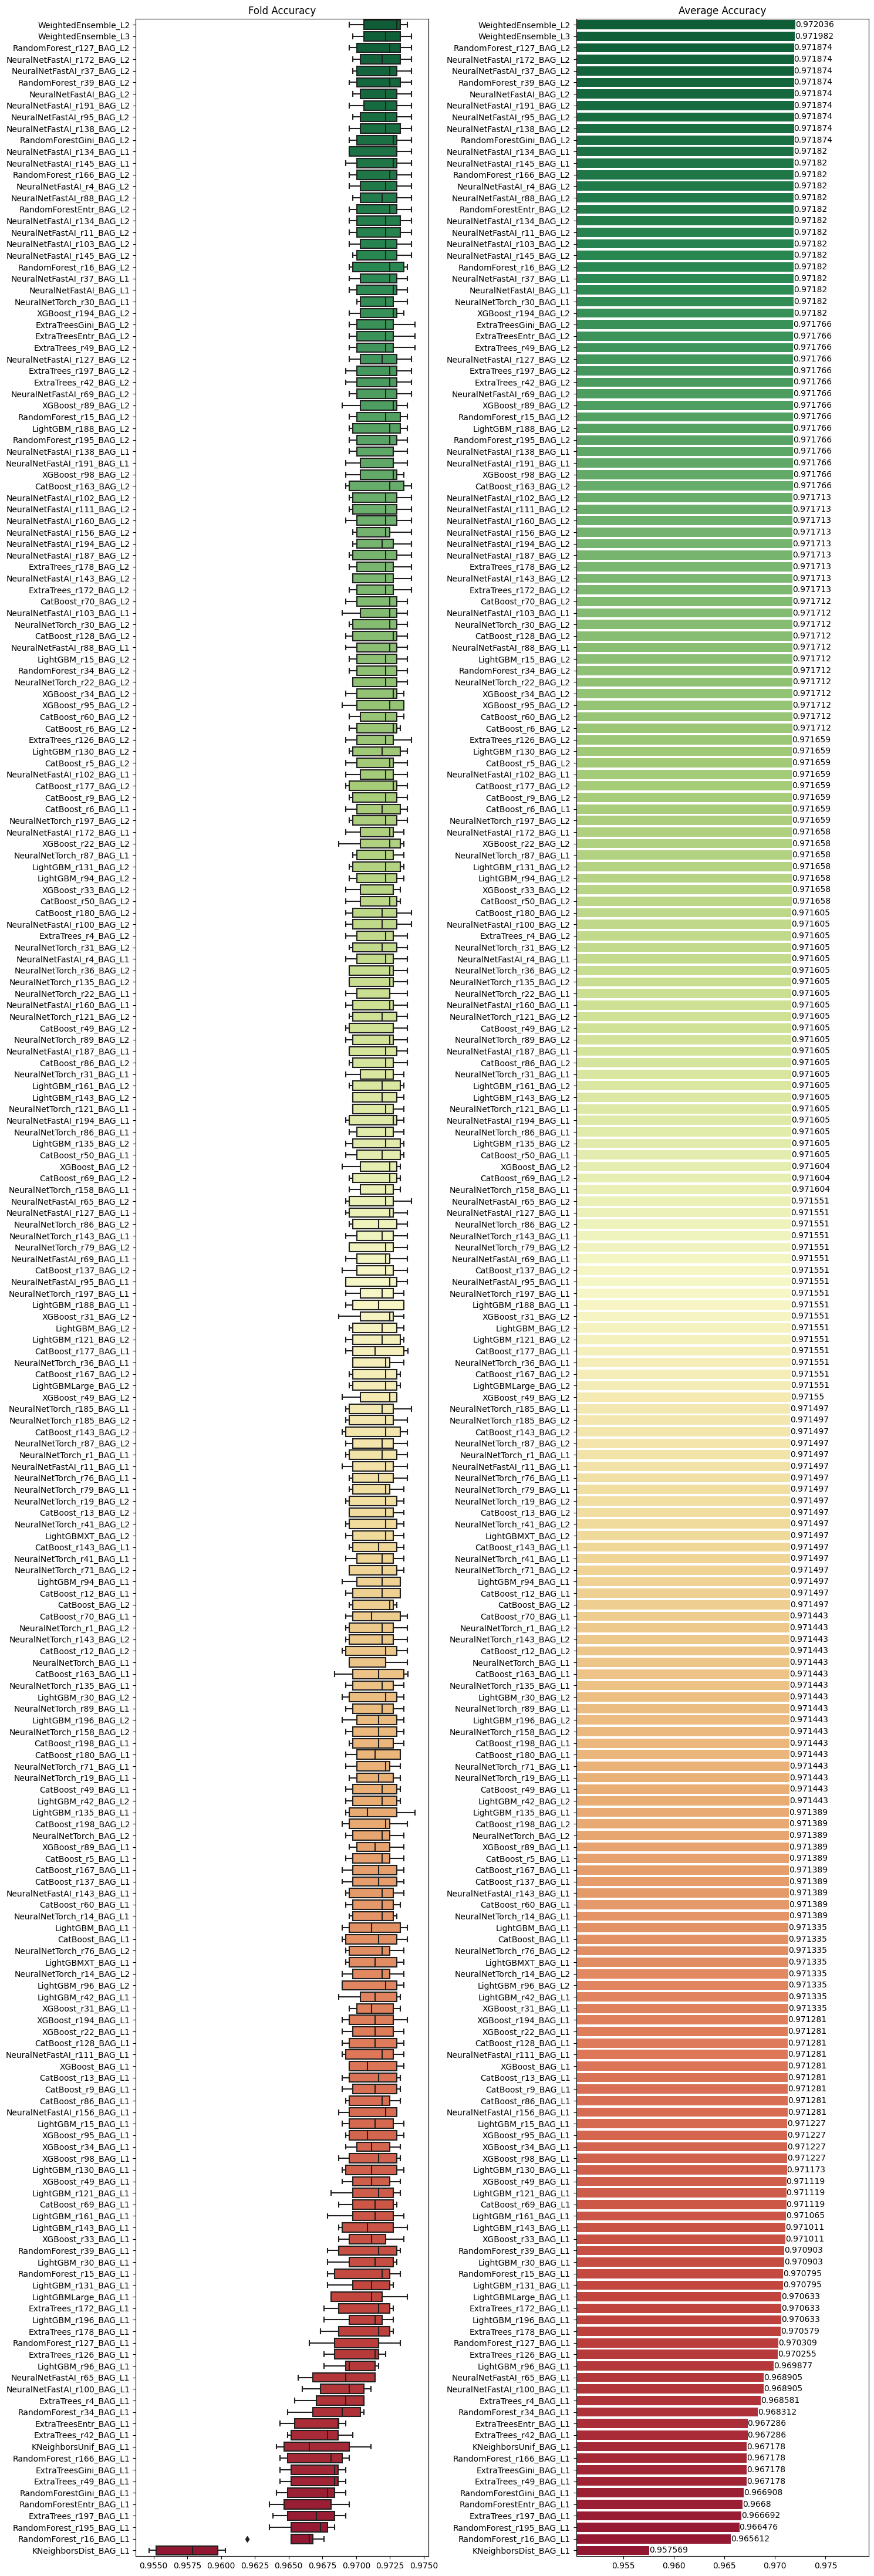

In [15]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.2))

sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title("Fold Accuracy")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette="RdYlGn_r")
axs[1].set_title("Average Accuracy")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()